### DATASET

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as Inception
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.layers import Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.layers import MaxPooling2D
from keras.models import Model, Sequential
from keras.models import load_model
from keras.utils import img_to_array, load_img
from keras.optimizers import Adam,SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [2]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.30)

In [3]:
path = 'C:/Users/iband/letras/letras/train'
BATCH_SIZE = 50

train_generator = data_generator.flow_from_directory(path, shuffle = True, 
                                                    seed=13, class_mode='categorical',
                                                    batch_size = BATCH_SIZE,
                                                    subset = "training")

validation_generator = data_generator.flow_from_directory(path, shuffle = True, 
                                                    seed=13, class_mode='categorical',
                                                    batch_size = BATCH_SIZE,
                                                    subset = "validation")

Found 414 images belonging to 3 classes.
Found 174 images belonging to 3 classes.


In [4]:
class_names = ['a','b','e']

In [5]:
def build_model(shape = (256,256)):
    
    model = Sequential()
    
    model.add(Conv2D(filters=64, kernel_size=2, activation='relu', input_shape=shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(filters=128, kernel_size=2, activation='relu', input_shape=shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(3, activation='sigmoid'))
    
    return model

In [6]:
model = build_model((32,32,3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 31, 64)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       32896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0

### DATA AUGMENTATION

In [7]:
core_idg = ImageDataGenerator(samplewise_center=False,
                             samplewise_std_normalization=False,
                             horizontal_flip=False,
                             vertical_flip=False,
                             height_shift_range=0.1,
                             width_shift_range=0.1,
                             brightness_range=[0.7, 1.5],
                             rotation_range=3,
                             shear_range=0.01,
                             fill_mode='nearest',
                             zoom_range=0.125,
                             rescale= 1./255)

### TRANSFER LEARNING

In [8]:
model_transfer_learning = tf.keras.applications.MobileNetV2(input_shape = (32,32,3), include_top = False, weights = 'imagenet')
model_transfer_learning.trainable = False
x = model_transfer_learning.output

x = GlobalAveragePooling2D()(x)
dense_layers = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
dense_layers = Dropout(0.3)(dense_layers)

out_layer = Dense(3, activation = 'sigmoid')(dense_layers)

final_model = Model(inputs = [model_transfer_learning.input], outputs = [out_layer],
                   name = 'final_model')

final_model.compile(optimizer = Adam(learning_rate = 1e-3), loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

In [9]:
checkpoint = ModelCheckpoint ('chest_orientation_model.hdf5',
                             monitor='val_loss',
                             verbose=1, mode='min',
                             save_best_only=True)

early_stop = EarlyStopping (monitor='val_loss',
                            min_delta=0.001,
                            patience=5,
                             verbose=1, mode='min')

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10,
                                  verbose=1, mode='auto', epsilon=0.0001,
                                  cooldown=5, min_lr=0.0001)

### MODEL

In [10]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size
history = final_model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data = validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs = 30,
    callbacks = [
        early_stop,
        checkpoint,
        reduceLROnPlat
    ],
    workers = 3
)

C:\Users\iband\AppData\Local\Temp\ipykernel_8248\3584831070.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = final_model.fit_generator(


Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.6361 - accuracy: 0.5220
Epoch 1: val_loss improved from inf to 0.39182, saving model to chest_orientation_model.hdf5
8/8 [==============================] - 28s 3s/step - loss: 0.6361 - accuracy: 0.5220 - val_loss: 0.3918 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.3703 - accuracy: 0.7825
Epoch 2: val_loss improved from 0.39182 to 0.32063, saving model to chest_orientation_model.hdf5
8/8 [==============================] - 27s 3s/step - loss: 0.3703 - accuracy: 0.7825 - val_loss: 0.3206 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.2878 - accuracy: 0.8654
Epoch 3: val_loss improved from 0.32063 to 0.27937, saving model to chest_orientation_model.hdf5
8/8 [==============================] - 25s 3s/step - loss: 0.2878 - accuracy: 0.8654 - val_loss: 0.2794 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 4/30
8/8 [=

In [11]:
def plot_model():

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(25)

    plt.gcf().clear()
    plt.figure(figsize = (15, 8))

    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')

    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend(loc = 'lower right')

    plt.show()
    

<Figure size 432x288 with 0 Axes>

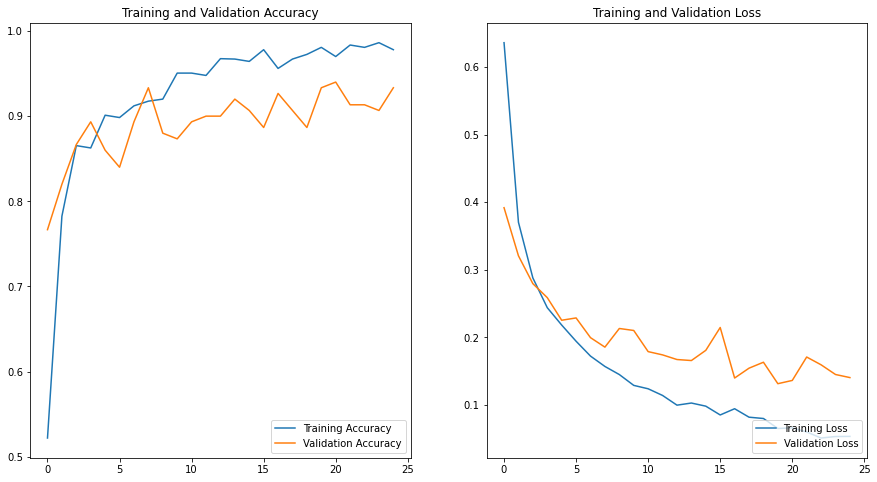

In [12]:
plot_model()

### PREDICTIONS

In [13]:
import glob

test_set = glob.glob('C:/Users/iband/letras/letras/test/*.png')

model = load_model('chest_orientation_model.hdf5')

image_test = np.array([img_to_array(load_img(image_name, target_size=(32, 32),
                                             color_mode='rgb'))/255 for image_name in test_set])

y_pred = model.predict(image_test)

1/1 [==============================] - 2s 2s/step


In [14]:
y_pred

array([[0.43628442, 0.7040792 , 0.17209226],
       [0.36308888, 0.78322464, 0.1720761 ],
       [0.4453795 , 0.59036857, 0.38463995],
       [0.4718417 , 0.5248588 , 0.43511313],
       [0.4929467 , 0.6235478 , 0.18163891],
       [0.45957562, 0.59375286, 0.30997312],
       [0.3047002 , 0.8219673 , 0.15088212],
       [0.39945662, 0.7317027 , 0.20947193],
       [0.40289217, 0.6724568 , 0.2571338 ]], dtype=float32)

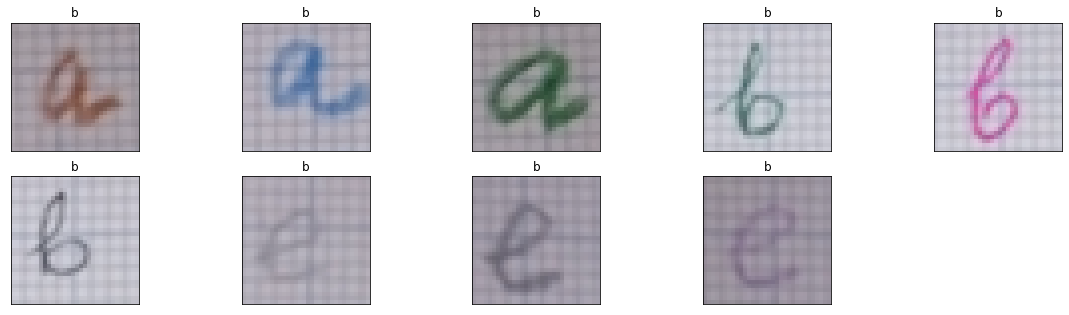

In [15]:
figure = plt.figure(figsize=(20,8))
for i in range(9):
    ax = figure.add_subplot(3, 5, i+1, xticks=[], yticks=[])
    
    im= plt.imread(test_set[i])
    ax.imshow(im)
    predict_index = np.argmax(y_pred[i])
    
    ax.set_title("{}".format(class_names[predict_index]))